### Setup

In [21]:
# databases
import psycopg2
import sqlparse
from neo4j import GraphDatabase

# external core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# utility
import getpass
from tqdm.notebook import tqdm

### PostgreSQL Login

In [13]:
# connect to postgres
pg_password = getpass.getpass("Enter Postgres Password: ")
pg = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password=pg_password,
    host="localhost",
    port="5433"
)

cur = pg.cursor()

### Neo4j Login

In [22]:
uri = "bolt://localhost:7666"
username = "neo4j"
password = "password"

def create_neo4j_session(uri, username, password):
    try:
        driver = GraphDatabase.driver(uri, auth=(username, password))
        session = driver.session()
        return session
    except Exception as e:
        print(f"Failed to create Neo4j session: {e}")
        return None

### Analysis

##### Identify all tables

In [4]:
query = "SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname='public';"
cur.execute(query)
table_names = cur.fetchall()

for table_name in table_names:
    print(table_name[0])

accidents
accident_info
accidents_on_road
roads
reports
reports_on_road


##### Visualize tables

In [4]:
def previewTable(tableName, endIdx, separator="\t   "):
    table_name = tableName
    table_query = f"SELECT * FROM {table_name};"

    cur.execute(table_query)
    column_names = [desc[0] for desc in cur.description]
    print(", ".join(column_names))
    rows = cur.fetchall()
    start = 0
    end = endIdx

    for r in rows:
        values = [str(value) for value in r]
        print(separator.join(values))
        start += 1
        if not (start-end):
            break

In [5]:
previewTable("accidents", 5, separator=",\t  ")

report_id, date_time, violation_section, violation_type, injured, killed, hit_run_lvl
171111,	  2015-01-14 20:00:00,	  MISC-HAZ,	  VC,	  0,	  0,	  MISDEMEANOR
192016,	  2015-03-19 12:00:00,	  MISC-HAZ,	  VC,	  0,	  0,	  MISDEMEANOR
190012,	  2015-03-24 03:05:00,	  22107,	  VC,	  2,	  0,	  
191866,	  2015-03-27 23:56:00,	  22107,	  VC,	  1,	  0,	  
185207,	  2015-07-06 11:45:00,	  20002(A),	  VC,	  0,	  0,	  MISDEMEANOR


In [6]:
previewTable("accident_info", 5, separator=", ")

report_id, person_role, veh_make, veh_model
171111, PARKED VEHICLE OCCUPANT, TOYOTA, RAV4
192016, PARKED VEHICLE OCCUPANT, FORD, 
190012, DRIVER, NISSAN, ALTIMA
191866, DRIVER, FORD, F150
185207, DRIVER, FORD, MUSTANG


In [7]:
previewTable("accidents_on_road", 2, separator=", ")

report_id, objectid
171111, 8708
192016, 2649


In [8]:
previewTable("roads", 5, separator=",\t  ")

objectid, roadsegid, roadid, road_name, speed, oneway, firedriv
17,	  2014,	  2225,	  08TH AV,	  20,	  T,	  Y
18,	  2027,	  2225,	  08TH AV,	  20,	  T,	  Y
19,	  2029,	  2225,	  08TH AV,	  20,	  T,	  Y
20,	  2031,	  2225,	  08TH AV,	  20,	  T,	  Y
21,	  2034,	  2225,	  08TH AV,	  20,	  B,	  Y


In [9]:
previewTable("reports", 5, separator=", ")

service_request_id, date_requested, case_age_days, service_name, service_name_detail, status, street_address, council_district, case_origin
100763, 2016-08-20 14:46:00, 2470, Street Sweeping, , In Process, 5135 University Avenue San Diego CA 92105 United States, 9, Web
100777, 2016-08-20 15:48:00, 2470, Sidewalk Repair Issue, SIDEWALK MINOR REHAB CONTRACT, In Process, 4300-4324 37th St San Diego CA 92105 USA, 9, Web
100985, 2016-08-22 10:04:00, 2468, Stormwater, DRAIN HEADWALL, In Process, 6175 NANCY RIDGE DR 92121, 6, Phone
101169, 2016-08-23 08:30:00, 2467, Pavement Maintenance, DAMAGED CURB, In Process, 2950-52 National Avenue San Diego, 8, Web
101707, 2016-08-25 15:01:00, 2465, Pavement Maintenance, DAMAGED CURB, In Process, 2220 Ocean View Boulevard San Diego CA United States, 8, Web


In [10]:
previewTable("reports_on_road", 5, separator=",\t\t   ")

service_request_id, objectid
100777,		   69508
100985,		   20182
101798,		   93638
101799,		   93638
101870,		   22009


##### Analyze Data

Question: Which road has the most felony and injury.

In [37]:
query = \
    """
    SELECT
        r.road_name,
        SUM(a.killed) AS total_killed,
        SUM(a.injured) AS total_injuries,
        COUNT(*) AS felony_count
    FROM
        accidents AS a
    JOIN
        accidents_on_road AS ar ON a.report_id = ar.report_id
    JOIN
        roads AS r ON ar.objectid = r.objectid
    WHERE
        (a.hit_run_lvl = 'FELONY' OR a.hit_run_lvl = 'MISDEMEANOR')
    GROUP BY
        r.road_name
    HAVING 
        COUNT(*) > 300
    ORDER BY
        -- total_killed DESC, total_injuries DESC 
        (CAST(SUM(a.killed) AS float) / CAST(COUNT(*) AS float)) DESC
    LIMIT 10;
    """

cur.execute(query)
result = cur.fetchall()

print(result)

[('LOGAN AV', 8, 99, 306), ('IMPERIAL AV', 4, 173, 659), ('COLLEGE AV', 3, 90, 506), ('LINDA VISTA RD', 2, 45, 342), ('EL CAJON BL', 4, 194, 978), ('EUCLID AV', 2, 129, 610), ('PRIVATE RD', 1, 29, 336), ('SUNSET CLIFFS BL', 1, 62, 372), ('UNIVERSITY AV', 4, 308, 1664), ('MARKET ST', 1, 175, 617)]


In [33]:
session = create_neo4j_session(uri, username, password)
accdident_total_2022 = []

for tup in result:
    road_name = tup[0]
    
    query = """
    MATCH (r:Road {name: $roadName})<-[:HAPPENS_ON]-(a:Accident)
    RETURN COUNT(a) AS accident_count
    """
    
    q_result = session.run(query, roadName=road_name)
    
    for r in q_result:
        accdident_total_2022.append(r["accident_count"])

session.close()
accdident_total_2022

Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))


[102, 290, 157, 81, 339, 158, 99, 101, 508, 233]

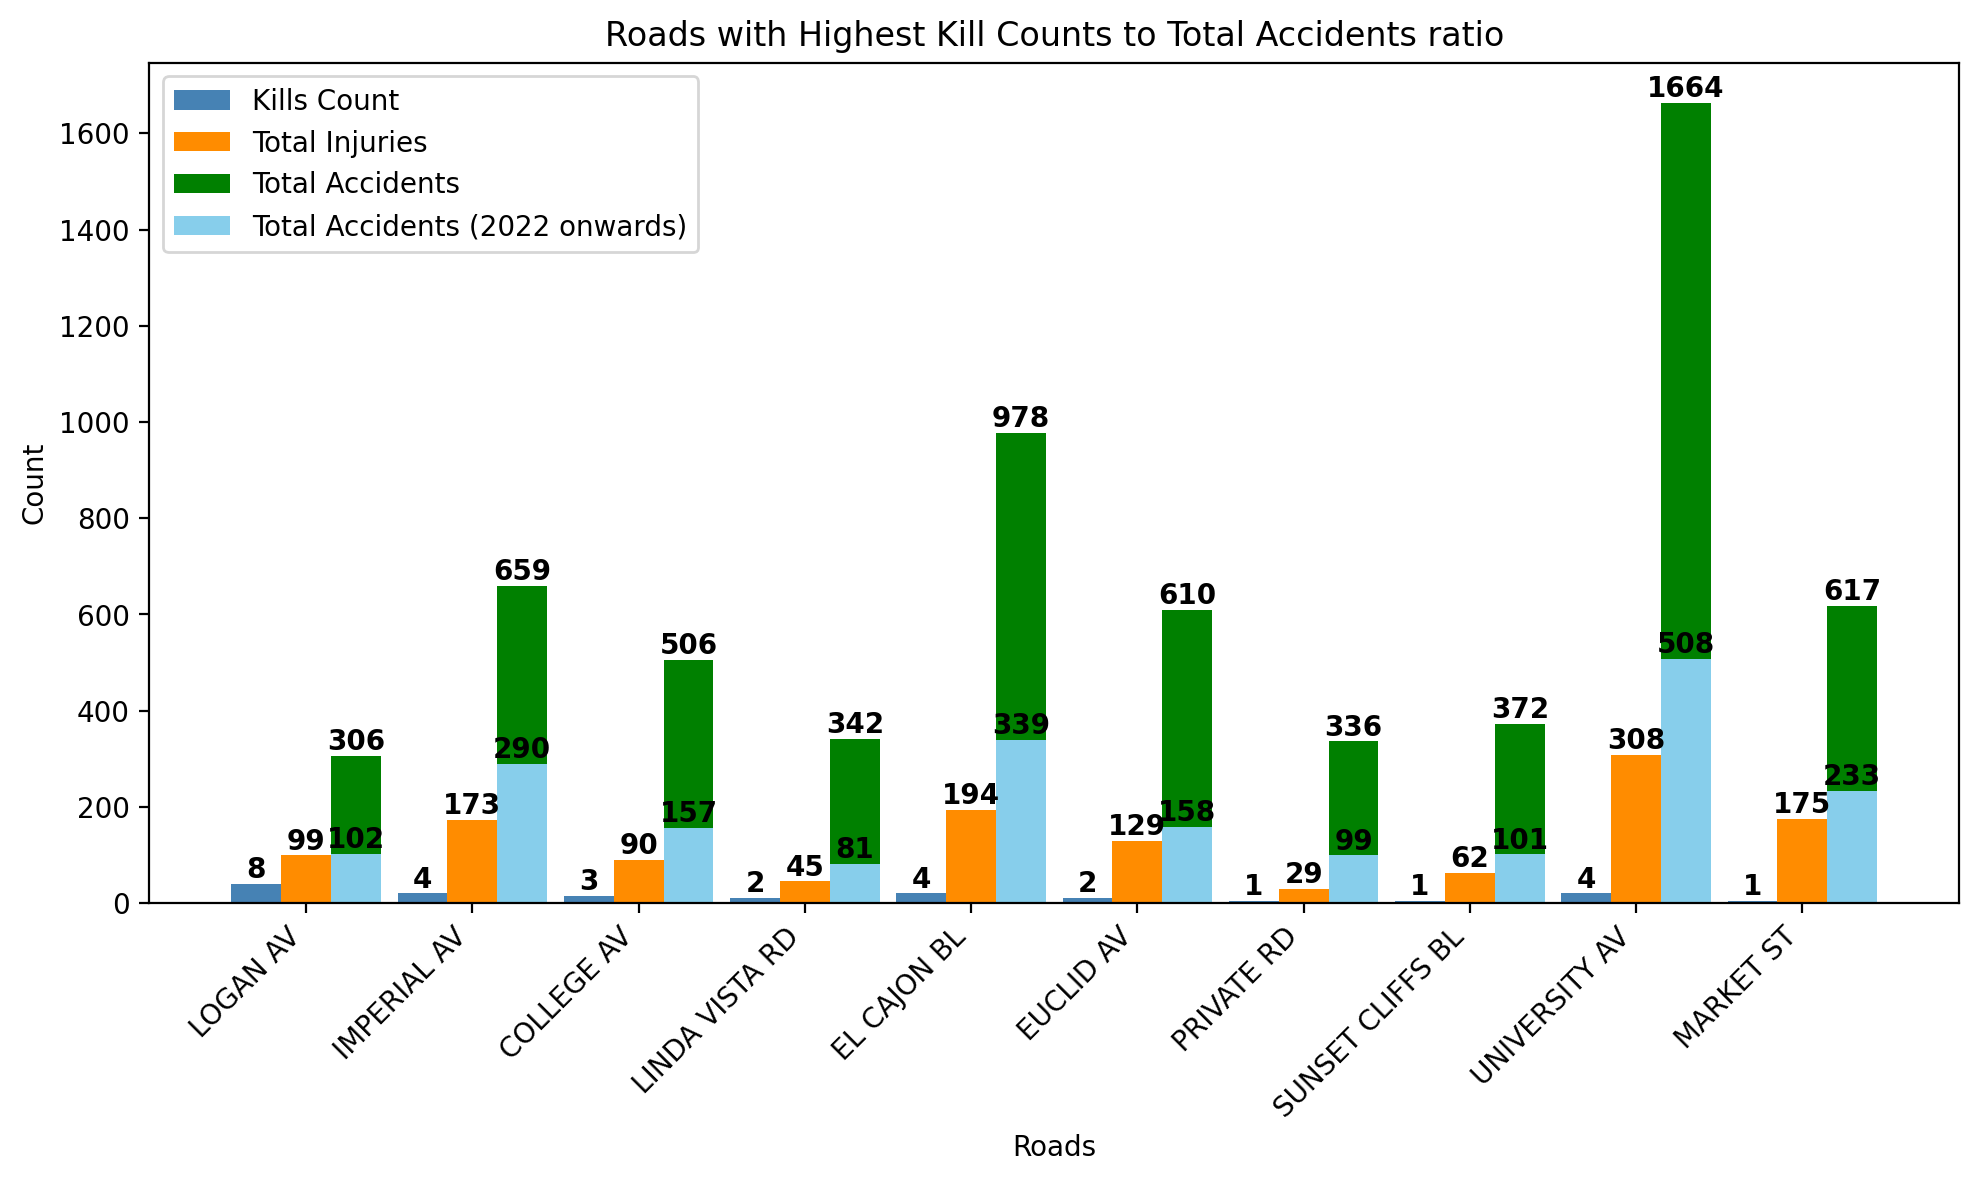

In [36]:
roads = [tup[0] for tup in result]
kill_counts = [tup[1] * 5 for tup in result]
injury_counts = [tup[2] for tup in result]
accident_counts = [tup[3] for tup in result]
accident_counts_2022 = accdident_total_2022

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3

index = np.arange(len(roads))
plt.bar(index, kill_counts, width=bar_width, color='steelblue', label='Kills Count')
plt.bar(index + bar_width, injury_counts, width=bar_width, color='darkorange', label='Total Injuries')
plt.bar(index + 2 * bar_width, accident_counts, width=bar_width, color='green', label='Total Accidents')
plt.bar(index + 2 * bar_width, accident_counts_2022, width=bar_width, color='skyblue', label='Total Accidents (2022 onwards)')

plt.xlabel('Roads')
plt.ylabel('Count')
plt.xticks(index + bar_width, roads, rotation=45, ha='right')

plt.legend()

for i, v in enumerate(kill_counts):
    plt.text(i, v, str(v // 5), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(injury_counts):
    plt.text(i + bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(accident_counts):
    plt.text(i + 2 * bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(accident_counts_2022):
    plt.text(i + 2 * bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.title('Roads with Highest Kill Counts to Total Accidents ratio')

plt.tight_layout()
plt.show()

Question: What is the top 10 vehicles that have highest (injury or kill) to total_accident rate 

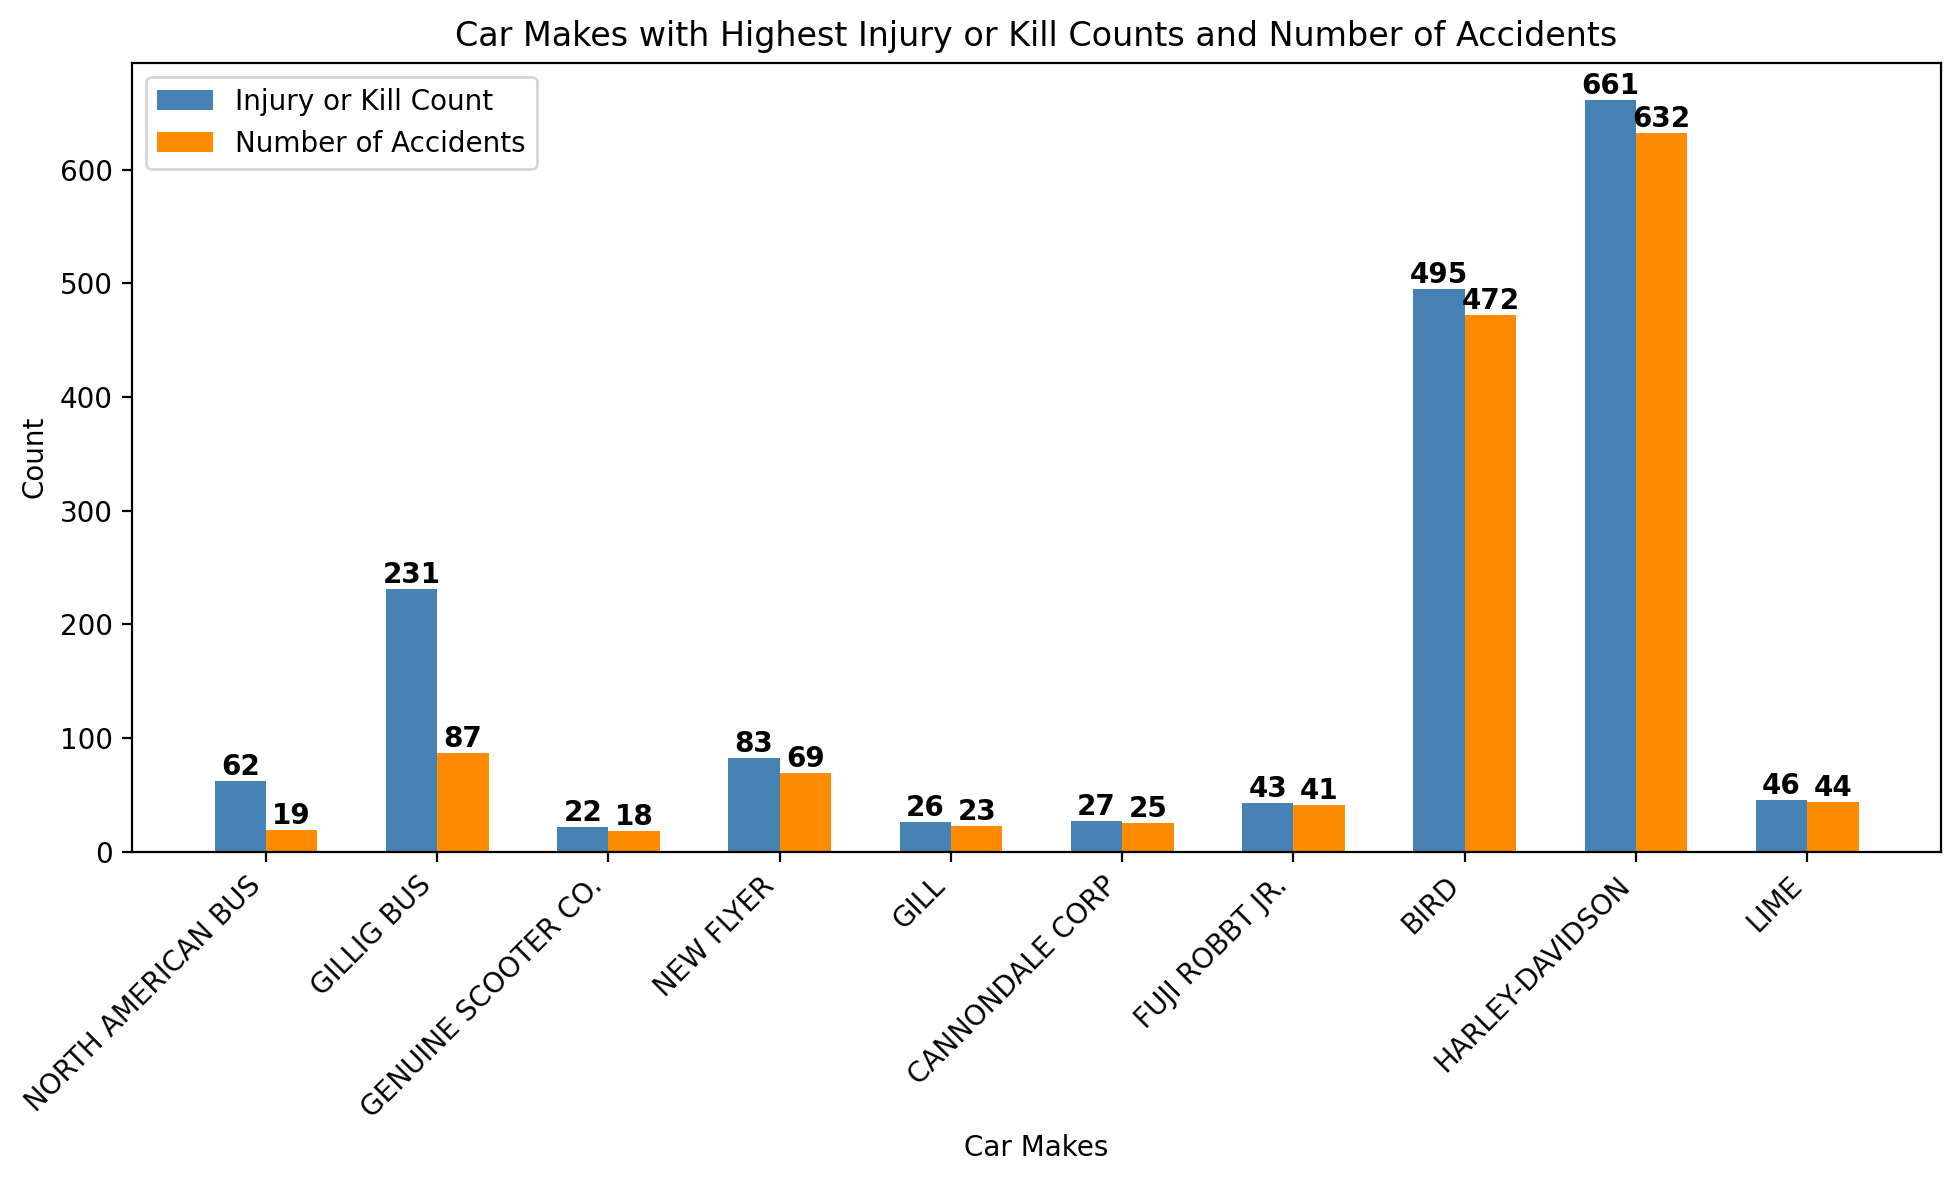

[('NORTH AMERICAN BUS', 62, 19), ('GILLIG BUS', 231, 87), ('GENUINE SCOOTER CO.', 22, 18), ('NEW FLYER', 83, 69), ('GILL', 26, 23), ('CANNONDALE CORP', 27, 25), ('FUJI ROBBT JR.', 43, 41), ('BIRD', 495, 472), ('HARLEY-DAVIDSON', 661, 632), ('LIME', 46, 44)]


In [57]:
query = \
    """
    SELECT 
        veh_make, SUM(injured + killed), COUNT(*)
    FROM accidents
    JOIN accident_info ON accidents.report_id = accident_info.report_id
    GROUP BY veh_make
    HAVING COUNT(*) > 15
    ORDER BY CAST(SUM(injured + killed) AS float) / CAST(COUNT(*) AS float) DESC
    LIMIT 10
    """

# query = "SELECT COUNT(DISTINCT veh_make) FROM accident_info"

cur.execute(query)
result = cur.fetchall()

car_makes = [tup[0] for tup in result]
injury_kill = [tup[1] for tup in result]
num_accident = [tup[2] for tup in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3

index = np.arange(len(car_makes))
plt.bar(index, injury_kill, width=bar_width, color='steelblue', label='Injury or Kill Count')
plt.bar(index + bar_width, num_accident, width=bar_width, color='darkorange', label='Number of Accidents')

plt.xlabel('Car Makes')
plt.ylabel('Count')
plt.xticks(index + bar_width/2, car_makes, rotation=45, ha='right')

plt.legend()

# Add labels to the bars
for i, v in enumerate(injury_kill):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(num_accident):
    plt.text(i + bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

# Add a title
plt.title('Car Makes with Highest Injury or Kill Counts and Number of Accidents')

# Show the plot
plt.tight_layout()
plt.show()

print(result)

Question: Which road would a particular vehicle have the most (injury and kills) to accident rate.

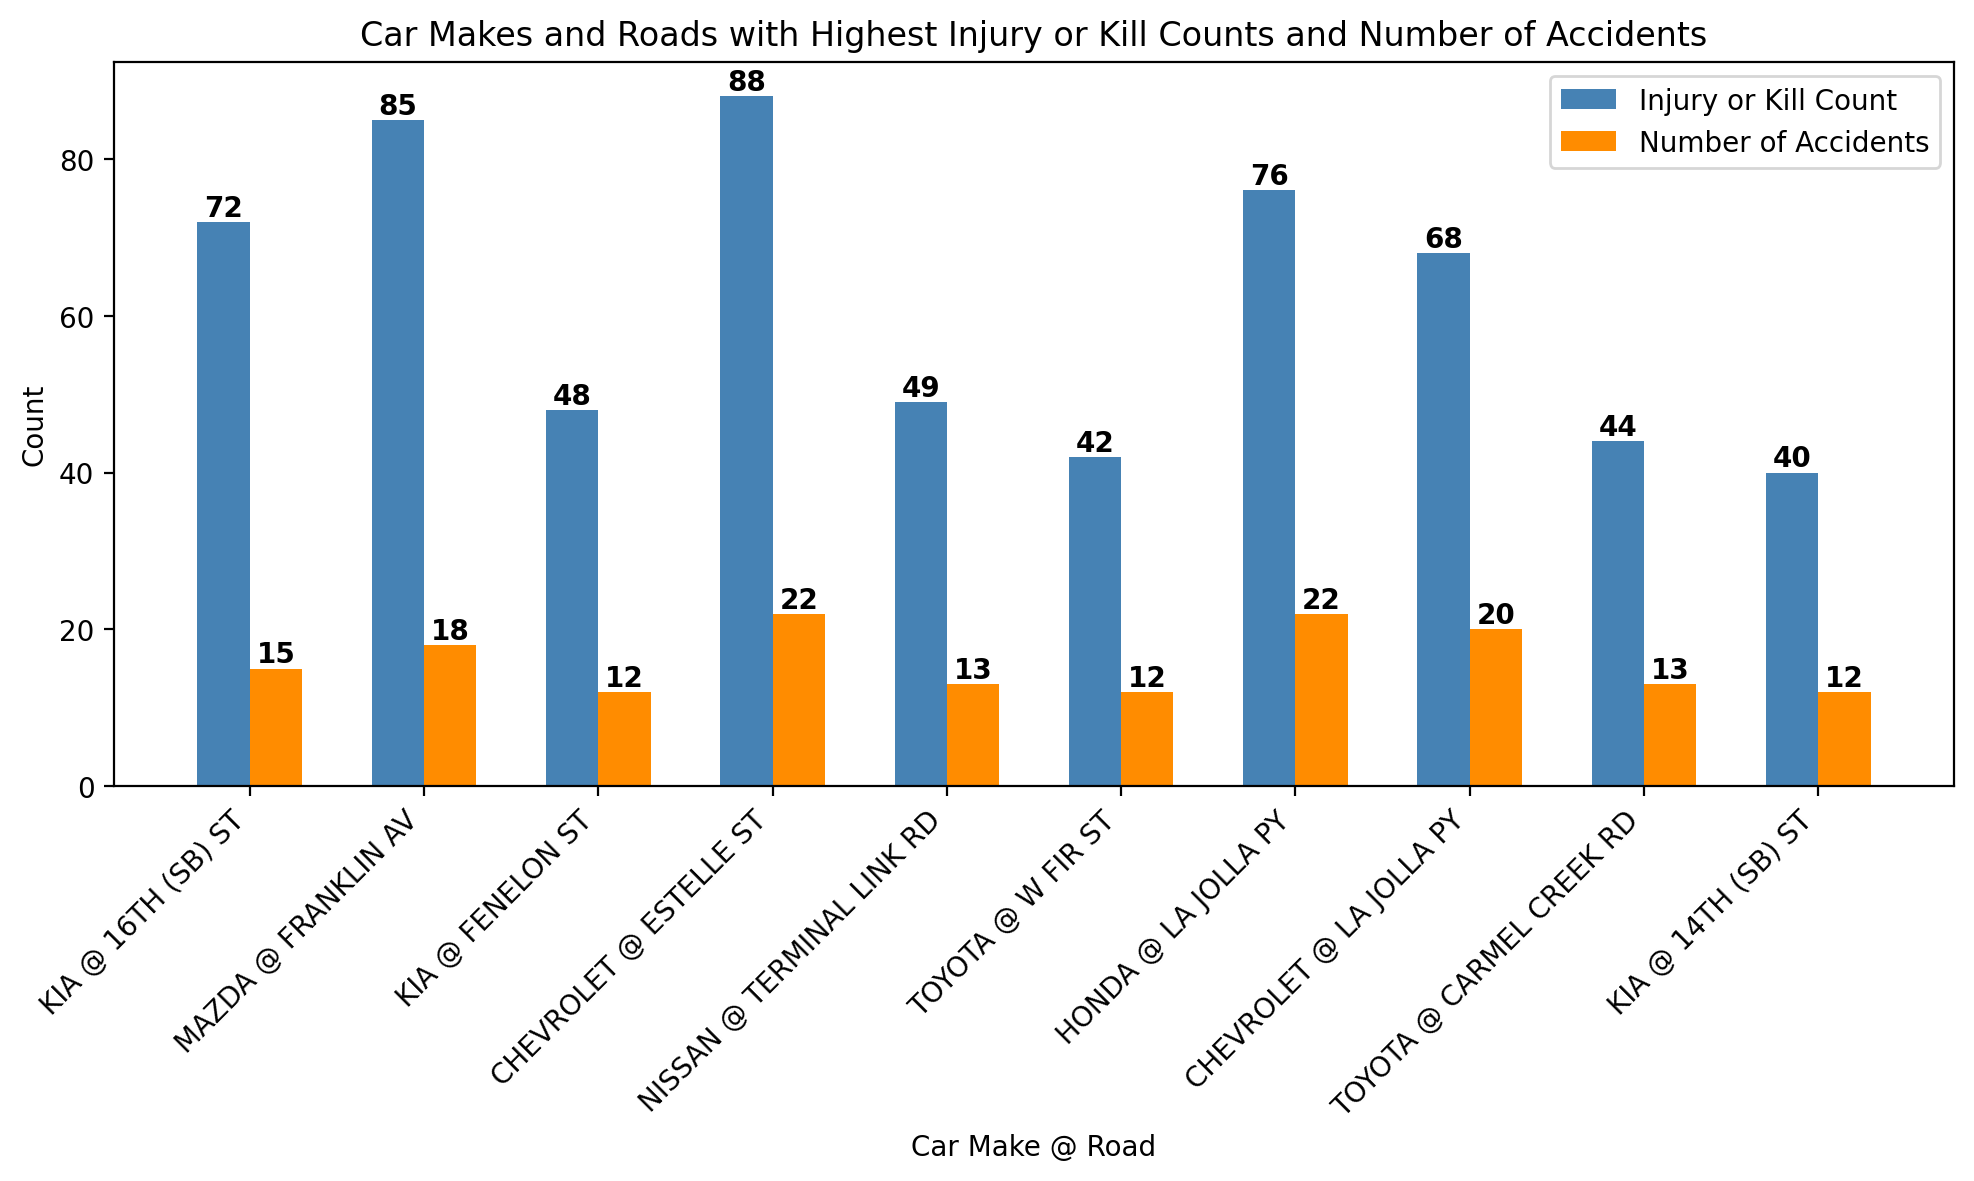

[('KIA', '16TH (SB) ST', 72, 15), ('MAZDA', 'FRANKLIN AV', 85, 18), ('KIA', 'FENELON ST', 48, 12), ('CHEVROLET', 'ESTELLE ST', 88, 22), ('NISSAN', 'TERMINAL LINK RD', 49, 13), ('TOYOTA', 'W FIR ST', 42, 12), ('HONDA', 'LA JOLLA PY', 76, 22), ('CHEVROLET', 'LA JOLLA PY', 68, 20), ('TOYOTA', 'CARMEL CREEK RD', 44, 13), ('KIA', '14TH (SB) ST', 40, 12)]


In [58]:
query = \
    """
    SELECT 
        veh_make, road_name, SUM(injured + killed), COUNT(*)
    FROM accidents
    INNER JOIN accident_info 
        ON accidents.report_id = accident_info.report_id
    INNER JOIN accidents_on_road
        ON accidents.report_id = accidents_on_road.report_id
    INNER JOIN roads
        ON accidents_on_road.objectid = roads.objectid
    GROUP BY veh_make, road_name
    HAVING COUNT(*) > 10
        AND SUM(injured + killed) < (COUNT(*) * 5)
    ORDER BY CAST(SUM(injured + killed) AS float) / CAST(COUNT(*) AS float) DESC
    LIMIT 10
    """

# query = "SELECT COUNT(DISTINCT veh_make) FROM accident_info"

cur.execute(query)
result = cur.fetchall()

car_road = [f"{tup[0]} @ {tup[1]}" for tup in result]
injury_kill = [tup[2] for tup in result]
num_accident = [tup[3] for tup in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3

index = np.arange(len(car_road))
plt.bar(index, injury_kill, width=bar_width, color='steelblue', label='Injury or Kill Count')
plt.bar(index + bar_width, num_accident, width=bar_width, color='darkorange', label='Number of Accidents')

plt.xlabel('Car Make @ Road')
plt.ylabel('Count')
plt.xticks(index + bar_width/2, car_road, rotation=45, ha='right')

plt.legend()

# Add labels to the bars
for i, v in enumerate(injury_kill):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(num_accident):
    plt.text(i + bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

# Add a title
plt.title('Car Makes and Roads with Highest Injury or Kill Counts and Number of Accidents')

# Show the plot
plt.tight_layout()
plt.show()

print(result)

In [12]:
cur.close()
pg.close()